<a href="https://colab.research.google.com/github/gkdivya/MLAssignment/blob/main/Experiments/Base_Skeleton_Model_PersonCar_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Person Car Detection 


In this notebook, we will train a model to localize and classify each instance of person and car in images using Object detection algorithm.

## Import Libraries

In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

## Dataset

Dataset present in: https://evp-ml-data.s3.us-east-2.amazonaws.com/mlinterview/openimages-personcar/trainval.tar.gz is used to train the model

In [2]:
# download the dataset
#wget http://evp-ml-data.s3.us-east-2.amazonaws.com/mlinterview/openimages-personcar/trainval.tar.gz


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!tar -xf  '/content/drive/MyDrive/MLAssignmentDS/trainval.tar.gz'

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
trainval/
  images/
    image_000000001.jpg
    image_000000001.jpg
    image_000000001.jpg
    image_000000001.jpg
    ...
  annotations/
    bbox-annotations.json
```

Here is one example of an image in the dataset:

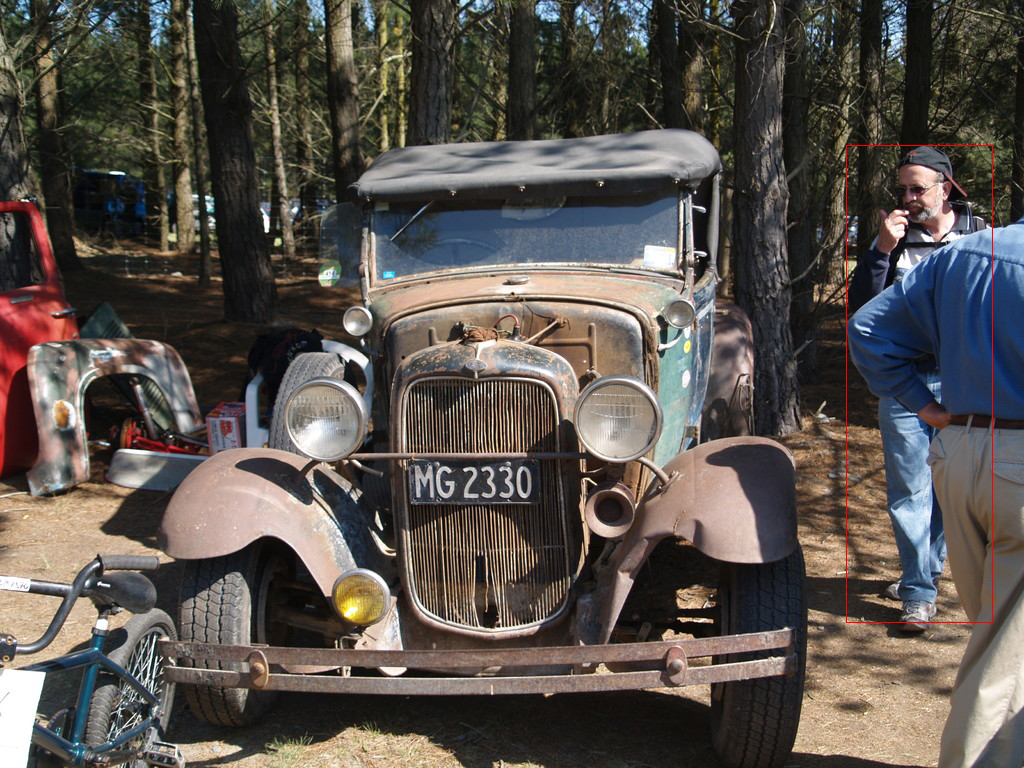

In [5]:
from PIL import Image, ImageDraw
img = Image.open('/content/trainval/images/image_000000001.jpg')
draw = ImageDraw.Draw(img)
shape = [(846, 145), (846 + 146, 145 + 477)] #Sample annotation of person

draw.rectangle(shape, outline ="red")
img.show()
img

## Writing a custom dataset for Person-Car dataset

Extracted from the below path
https://evp-ml-data.s3.us-east-2.amazonaws.com/mlinterview/openimages-personcar/trainval.tar.gz

## Defining the Dataset

Custom dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible.



      "category_id": 1,
      "image_id": 0,
      "segmentation": [],
      "iscrowd": 0,
      "bbox": [
        846,
        145,
        146,
        477
      ],

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [6]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-j8gm6n0k
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-j8gm6n0k
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263916 sha256=efb0313b00356418aee74622762ffe1b3b9bf1731813e180f1ad33387d6bd13f
  Stored in directory: /tmp/pip-ephem-wheel-cache-autth5sw/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [7]:
class PersonCarDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]

            if(((xmax-xmin) <= 0) or ((ymax-ymin) <= 0)):
              pass
            else:
              boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        data_annotation = {}
        data_annotation["boxes"] = boxes
        data_annotation["labels"] = labels
        data_annotation["image_id"] = img_id
        data_annotation["area"] = areas
        data_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, data_annotation

    def __len__(self):
        return len(self.ids)

### Data Augmentation/Transformation


In [8]:
def get_transform(train=True):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    # Not adding mean/std normalization nor image rescaling in the data transforms, 
    # as those are handled internally by the Mask R-CNN model
    transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(transforms)

# path to your own data and coco file
train_data_dir = '/content/trainval/images'
train_coco = '/content/trainval/annotations/bbox-annotations.json'

# create own Dataset
dataset = PersonCarDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size = 16
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, collate_fn=collate_fn)



loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [9]:
print(len(dataset))
print(len(train_loader))
print(len(validation_loader))
indices = list(range(dataset_size))
indices[len(indices)-1]

2239
112
28


2238

In [12]:
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True,collate_fn=lambda x:list(zip(*x)))
validation_loader = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=False,collate_fn=lambda x:list(zip(*x)))

That's all for the dataset. Let's see how the outputs are structured for this dataset

The dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes` and `labels`.

## Defining model

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

We want to start from a pre-trained model, and just finetune the last layer for predicting person and car.

### 1 - Finetuning from a pretrained model

Let's start from a model pre-trained on COCO and finetune it for person and car classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + 2 (car)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# 2 classes; Only target class or background
num_classes = 2
num_epochs = 5
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in train_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch: {epoch}, Loss: {losses}')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch: 0, Loss: 1.7864028215408325
Epoch: 1, Loss: 0.3092164397239685
Epoch: 2, Loss: 0.3485269248485565
Epoch: 3, Loss: 0.36063939332962036
Epoch: 4, Loss: 0.8723194003105164


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [14]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 26496, done.
remote: Counting objects: 100% (4105/4105), done.
remote: Compressing objects: 100% (1053/1053), done.
remote: Total 26496 (delta 3136), reused 3848 (delta 2976), pack-reused 22391
Receiving objects: 100% (26496/26496), 34.67 MiB | 36.34 MiB/s, done.
Resolving deltas: 100% (19710/19710), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [16]:
#print(person_car_dataset[0])
# pick one image from the test set
img = dataset[val_indices[0]][0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [17]:
prediction

[{'boxes': tensor([[  78.0782,   77.3706,  931.3969,  581.3530],
          [ 543.4637,  142.7385,  597.1935,  180.1418],
          [ 294.6064,   97.1710,  319.2818,  120.8403],
          [  11.4996,   82.6650,  271.2064,  425.9084],
          [ 368.2242,   86.3241,  423.8683,  167.1034],
          [   4.6363,   81.3736,  513.1436,  432.1393],
          [ 542.4667,  152.5044,  562.9860,  182.0789],
          [ 102.6205,  108.3712,  171.7810,  158.9010],
          [ 182.5016,  107.5387,  463.2607,  285.0454],
          [ 560.9485,  141.7373,  591.3381,  176.0086],
          [ 552.6670,  145.9223,  580.9535,  181.0675],
          [ 355.0564,   91.0219,  435.2429,  200.8890],
          [ 371.2338,   84.8216,  415.0561,  132.1880],
          [ 203.7427,   94.3024,  430.5447,  412.5360],
          [ 463.6769,   57.0535,  944.1506,  498.2977],
          [ 290.4259,   94.3992,  322.0758,  139.5222],
          [ 411.9362,   98.9927,  422.3286,  116.9324],
          [ 977.9283,   84.5113, 1016.4

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

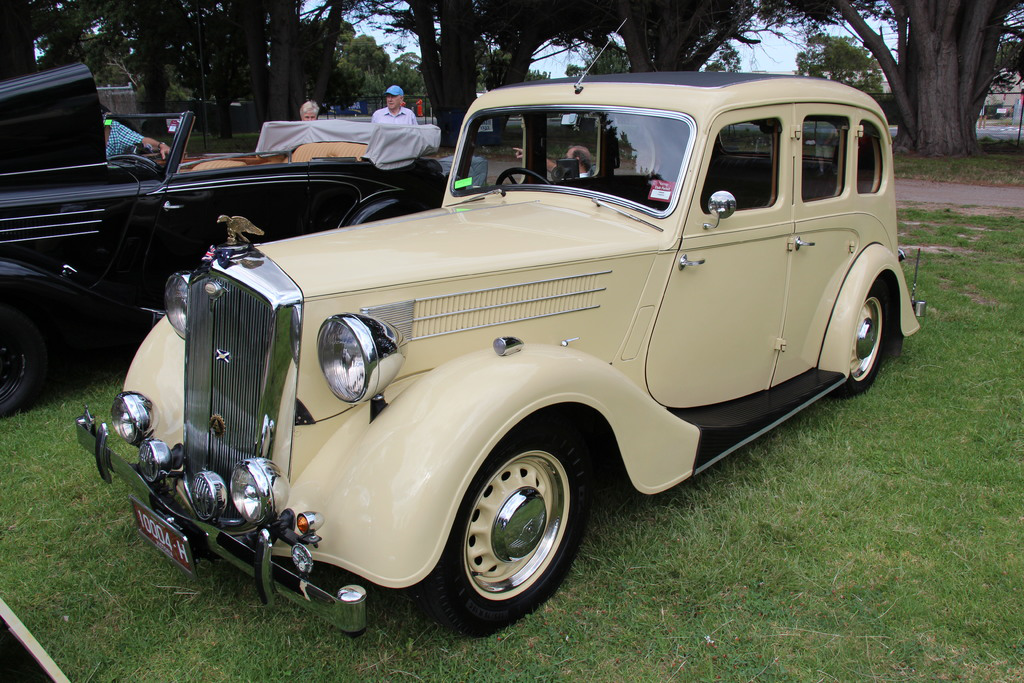

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [19]:
import numpy as np

# If the box classification value is less than this, we ignore this box
score_threshold = 0.7

image_outputs = []

boxes = prediction[0]['boxes'].data.cpu().numpy()
scores = prediction[0]['scores'].data.cpu().numpy()

mask = scores >= score_threshold
boxes = boxes[mask].astype(np.int32)
scores = scores[mask]
image_outputs.append((boxes, scores))

In [20]:
image_outputs

[(array([[ 78,  77, 931, 581],
         [543, 142, 597, 180],
         [294,  97, 319, 120],
         [ 11,  82, 271, 425],
         [368,  86, 423, 167],
         [  4,  81, 513, 432]], dtype=int32),
  array([0.96134466, 0.93062377, 0.9305729 , 0.84311754, 0.820665  ,
         0.79924005], dtype=float32))]

[[ 78  77 931 581]
 [543 142 597 180]
 [294  97 319 120]
 [ 11  82 271 425]
 [368  86 423 167]
 [  4  81 513 432]]


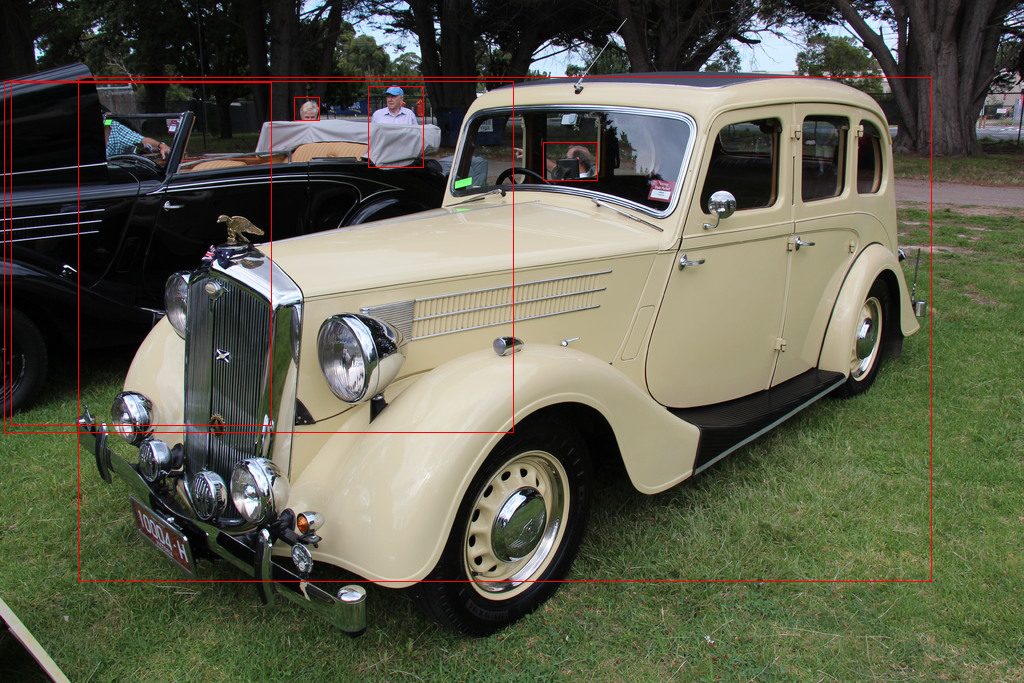

In [24]:
from PIL import Image, ImageDraw
boxes, scores = image_outputs[0]
print(boxes)

img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(img)
for box in boxes:
  shape = [box[0], box[1], box[2], box[3]] #Sample annotation of person
  draw.rectangle(shape, outline ="red")
img.show()
img
